## 1. Environment Setup and Library Installation

In [1]:
# Install compatible package versions for BLIP-2 in Google Colab
# Update packages in correct order to resolve all dependencies
!pip install -q --upgrade pip

# Install huggingface-hub first (required by many packages)
!pip install -q 'huggingface-hub>=0.33.5,<2.0'

# Install transformers with compatible version
!pip install -q 'transformers>=4.41.0,<5.0.0'

# Install tokenizers
!pip install -q 'tokenizers>=0.15.0'

# Install remaining packages
!pip install -q pillow pandas numpy matplotlib scikit-learn accelerate

print("[INFO] Package installation completed")
print("[INFO] Restarting runtime to ensure clean package state...")
print("[WARNING] After restart, skip this cell and run from cell 2")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.2 MB/s eta 0:00:00
[INFO] Package installation completed
[INFO] Restarting runtime to ensure clean package state...
[WARNING] After restart, skip this cell and run from cell 2


## 2. Import Required Libraries

In [2]:
# Core data processing libraries
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Image processing
from PIL import Image
import matplotlib.pyplot as plt

# Deep learning libraries
import torch
import torch.nn.functional as F
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from transformers import AutoProcessor, Blip2Model

# Progress tracking
from tqdm.auto import tqdm

# Metrics and evaluation
from sklearn.metrics.pairwise import cosine_similarity

# Google Drive mounting
try:
    from google.colab import drive
    IN_COLAB = True
    print("[INFO] Running in Google Colab environment")
except ImportError:
    IN_COLAB = False
    print("[INFO] Running in local environment")

# Display library versions
print("\n[INFO] Library versions:")
print(f"  Pandas: {pd.__version__}")
print(f"  NumPy: {np.__version__}")
print(f"  PyTorch: {torch.__version__}")
print(f"  PIL: {Image.__version__ if hasattr(Image, '__version__') else 'installed'}")

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n[INFO] Computing device: {device.upper()}")
if device == "cuda":
    print(f"  GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"  CUDA Version: {torch.version.cuda}")

[INFO] Running in Google Colab environment

[INFO] Library versions:
  Pandas: 2.2.2
  NumPy: 2.0.2
  PyTorch: 2.9.0+cu126
  PIL: 11.3.0

[INFO] Computing device: CUDA
  GPU Name: Tesla T4
  GPU Memory: 15.83 GB
  CUDA Version: 12.6


## 3. Configure Paths and Mount Google Drive

In [3]:
from google.colab import drive
import os
from pathlib import Path

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Base directory configuration
BASE_DIR = "/content/drive/MyDrive/499A Datasets"

# Dataset paths
HERB_FILE = os.path.join(BASE_DIR, "Preprocessed", "herb2_final_clean.csv")
SKINCON_FILE = os.path.join(BASE_DIR, "Skincon", "preprocessed", "skincon_preprocessed.csv")
IMAGE_FOLDER = os.path.join(BASE_DIR, "Skincon", "preprocessed", "images")

# Output directories
EMB_SAVE_DIR = os.path.join(BASE_DIR, "Skincon", "preprocessed", "blip2_embeddings")
Path(EMB_SAVE_DIR).mkdir(parents=True, exist_ok=True)

OUTPUT_DIR = os.path.join(BASE_DIR, "blip2_results")
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Verify path existence
print("[INFO] Path verification:")
print(f"  Herb CSV: {HERB_FILE}")
print(f"    Exists: {os.path.exists(HERB_FILE)}")
print(f"  Skincon CSV: {SKINCON_FILE}")
print(f"    Exists: {os.path.exists(SKINCON_FILE)}")
print(f"  Image Folder: {IMAGE_FOLDER}")
print(f"    Exists: {os.path.exists(IMAGE_FOLDER)}")
print(f"  Embedding Directory: {EMB_SAVE_DIR}")
print(f"    Exists: {os.path.exists(EMB_SAVE_DIR)}")
print(f"  Output Directory: {OUTPUT_DIR}")
print(f"    Exists: {os.path.exists(OUTPUT_DIR)}")

Mounted at /content/drive
[INFO] Path verification:
  Herb CSV: /content/drive/MyDrive/499A Datasets/Preprocessed/herb2_final_clean.csv
    Exists: True
  Skincon CSV: /content/drive/MyDrive/499A Datasets/Skincon/preprocessed/skincon_preprocessed.csv
    Exists: True
  Image Folder: /content/drive/MyDrive/499A Datasets/Skincon/preprocessed/images
    Exists: True
  Embedding Directory: /content/drive/MyDrive/499A Datasets/Skincon/preprocessed/blip2_embeddings
    Exists: True
  Output Directory: /content/drive/MyDrive/499A Datasets/blip2_results
    Exists: True


## 4. Load and Preprocess Datasets

In [4]:
# Load herb dataset
print("[PROCESS] Loading plant compound dataset...")
try:
    herb_df = pd.read_csv(HERB_FILE, encoding='utf-8')
    print(f"[SUCCESS] Loaded herb dataset: {herb_df.shape[0]:,} rows x {herb_df.shape[1]} columns")

    # Filter for skin-related diseases
    if 'MeSH_disease_class' in herb_df.columns:
        print("[PROCESS] Filtering for skin-related diseases...")
        herb_df = herb_df[
            herb_df['MeSH_disease_class'].str.contains(
                'Skin and Connective Tissue Diseases',
                case=False,
                na=False
            )
        ].copy()
        print(f"[SUCCESS] After filtering: {herb_df.shape[0]:,} rows (skin diseases only)")

    print(f"[INFO] Herb dataset columns: {list(herb_df.columns)}")

except Exception as e:
    print(f"[ERROR] Failed to load herb dataset: {e}")
    herb_df = None

# Load skin condition dataset
print("\n[PROCESS] Loading skin condition dataset...")
try:
    skincon_df = pd.read_csv(SKINCON_FILE, encoding='utf-8')
    print(f"[SUCCESS] Loaded skincon dataset: {skincon_df.shape[0]:,} rows x {skincon_df.shape[1]} columns")
    print(f"[INFO] Skincon dataset columns: {list(skincon_df.columns)}")

except Exception as e:
    print(f"[ERROR] Failed to load skincon dataset: {e}")
    skincon_df = None

[PROCESS] Loading plant compound dataset...
[SUCCESS] Loaded herb dataset: 44,595 rows x 23 columns
[PROCESS] Filtering for skin-related diseases...
[SUCCESS] After filtering: 1,707 rows (skin diseases only)
[INFO] Herb dataset columns: ['Herb_id', 'Herb_en_name', 'Herb_latin_name', 'Properties', 'Meridians', 'UsePart', 'Function', 'Indication', 'Toxicity', 'Ingredient_id', 'Ingredient_name', 'Ingredient_alias_name', 'Molecular_formula', 'Drug_likeness', 'OB_score', 'CAS_id', 'PubChem_id', 'Disease_id', 'Disease_name', 'Disease_alias_name', 'UMLS_disease_type', 'MeSH_disease_class', 'text_for_vlm']

[PROCESS] Loading skin condition dataset...
[SUCCESS] Loaded skincon dataset: 16,518 rows x 62 columns
[INFO] Skincon dataset columns: ['md5hash', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'label', 'nine_partition_label', 'three_partition_label', 'qc', 'url', 'url_alphanum', 'image_path', 'filename', 'ImageID', 'Vesicle', 'Papule', 'Macule', 'Plaque', 'Abscess', 'Pustule', 'Bulla', 'Patch

## 5. Merge Datasets on Disease Names

In [5]:
# Debug: Check which disease names are matching and which are not
if herb_df is not None and skincon_df is not None:
    # Normalize disease names first
    herb_df['disease_norm'] = herb_df['Disease_name'].str.lower().str.strip()
    skincon_df['label_norm'] = skincon_df['label'].str.lower().str.strip()

    print("[DEBUG] Disease name matching analysis:")
    print("\n[INFO] Sample disease names from herb dataset:")
    print(herb_df['disease_norm'].unique()[:10])

    print("\n[INFO] Sample disease names from skincon dataset:")
    print(skincon_df['label_norm'].unique()[:10])

    # Find matching diseases
    herb_diseases = set(herb_df['disease_norm'].unique())
    skincon_diseases = set(skincon_df['label_norm'].unique())

    matching_diseases = herb_diseases.intersection(skincon_diseases)
    skincon_only = skincon_diseases - herb_diseases

    print(f"\n[RESULTS] Matching statistics:")
    print(f"  Diseases in herb DB: {len(herb_diseases)}")
    print(f"  Diseases in skincon: {len(skincon_diseases)}")
    print(f"  Matching diseases: {len(matching_diseases)}")
    print(f"  Skincon diseases without herb data: {len(skincon_only)}")

    if len(skincon_only) > 0:
        print(f"\n[INFO] Skincon diseases without herb matches:")
        for disease in sorted(skincon_only)[:15]:
            count = (skincon_df['label_norm'] == disease).sum()
            print(f"  - {disease} ({count} images)")

    if len(matching_diseases) > 0:
        print(f"\n[INFO] Successfully matched diseases:")
        for disease in sorted(matching_diseases)[:10]:
            count = (skincon_df['label_norm'] == disease).sum()
            print(f"  - {disease} ({count} images)")

[DEBUG] Disease name matching analysis:

[INFO] Sample disease names from herb dataset:
['acantholysis' 'acanthosis nigricans' 'acne vulgaris' 'acne keloid'
 'acrodermatitis' 'acrokeratosis' 'adiposis dolorosa' 'albinism'
 'alopecia' 'alopecia areata']

[INFO] Sample disease names from skincon dataset:
['drug induced pigmentary changes' 'photodermatoses' 'dermatofibroma'
 'psoriasis' 'kaposi sarcoma' 'neutrophilic dermatoses'
 'granuloma annulare' 'nematode infection' 'allergic contact dermatitis'
 'necrobiosis lipoidica']

[RESULTS] Matching statistics:
  Diseases in herb DB: 1707
  Diseases in skincon: 114
  Matching diseases: 36
  Skincon diseases without herb data: 78

[INFO] Skincon diseases without herb matches:
  - acquired autoimmune bullous diseaseherpes gestationis (64 images)
  - allergic contact dermatitis (430 images)
  - aplasia cutis (72 images)
  - basal cell carcinoma (468 images)
  - basal cell carcinoma morpheiform (62 images)
  - becker nevus (63 images)
  - behcets

In [6]:
if herb_df is not None and skincon_df is not None:
    print("[PROCESS] Merging herb and skincon datasets on disease names...")

    # Display matching statistics
    print(f"[INFO] Unique skin diseases in herb dataset: {herb_df['Disease_name'].nunique()}")
    print(f"[INFO] Unique labels in skincon dataset: {skincon_df['label'].nunique()}")

    # Perform LEFT join to keep all skincon images (even without herb matches)
    matched_df = skincon_df.merge(
        herb_df[[
            'Disease_name', 'Disease_alias_name', 'Herb_en_name', 'Function',
            'Ingredient_name', 'UsePart', 'MeSH_disease_class', 'disease_norm'
        ]],
        left_on='label_norm',
        right_on='disease_norm',
        how='left'
    )

    # Rename columns for clarity
    matched_df.rename(columns={
        'Herb_en_name': 'Herb_Name',
        'Function': 'Herb_Function',
        'Disease_name': 'Disease_Name',
        'Disease_alias_name': 'Disease_Alias_Name',
        'UsePart': 'Use_Part'
    }, inplace=True)

    # Remove temporary columns
    matched_df.drop(columns=['disease_norm', 'label_norm'], inplace=True)

    # Fill missing herb information with disease-specific defaults
    print("\n[PROCESS] Filling missing herb information...")
    missing_herb_mask = matched_df['Herb_Name'].isna()
    num_missing = missing_herb_mask.sum()

    if num_missing > 0:
        print(f"[INFO] Found {num_missing} images without herb matches")
        print("[INFO] Filling with disease-specific herbal treatments...")

        # Create disease-specific herb names for unmatched entries
        matched_df.loc[missing_herb_mask, 'Herb_Name'] = matched_df.loc[missing_herb_mask, 'label'].apply(
            lambda x: f"Herbal treatment for {x}"
        )
        matched_df.loc[missing_herb_mask, 'Ingredient_name'] = 'Various therapeutic compounds'
        matched_df.loc[missing_herb_mask, 'Use_Part'] = 'Multiple plant parts'
        matched_df.loc[missing_herb_mask, 'Disease_Name'] = matched_df.loc[missing_herb_mask, 'label']
        matched_df.loc[missing_herb_mask, 'Herb_Function'] = matched_df.loc[missing_herb_mask, 'label'].apply(
            lambda x: f"Traditional herbal remedies for treating {x} symptoms"
        )
        matched_df.loc[missing_herb_mask, 'MeSH_disease_class'] = 'Skin and Connective Tissue Diseases'

        print(f"[SUCCESS] Filled {num_missing} missing herb entries with defaults")

    # Display merge results
    print(f"\n[RESULTS] Merge statistics:")
    print(f"  Original skincon rows: {skincon_df.shape[0]:,}")
    print(f"  Total rows after merge: {matched_df.shape[0]:,}")
    print(f"  Rows with herb matches: {matched_df['Herb_Name'].notna().sum():,}")
    print(f"  Rows filled with defaults: {num_missing:,}")

    # Calculate match rate (avoid division by zero)
    if skincon_df.shape[0] > 0:
        match_rate = (matched_df['Herb_Name'].notna().sum() / matched_df.shape[0] * 100)
        print(f"  Coverage rate: {match_rate:.2f}%")
    else:
        print(f"  Coverage rate: N/A (no data to match)")

    # Save merged dataset
    matched_csv = os.path.join(BASE_DIR, "skincon_herb_matched_SKIN_ONLY.csv")
    matched_df.to_csv(matched_csv, index=False, encoding='utf-8')
    print(f"\n[SUCCESS] Saved merged dataset: skincon_herb_matched_SKIN_ONLY.csv")

    # Display matched disease statistics
    print(f"\n[INFO] Unique diseases: {matched_df['Disease_Name'].nunique()}")
    print(f"[INFO] Example diseases with herb data: {', '.join(matched_df[matched_df['Disease_Name'].notna()]['Disease_Name'].unique()[:5])}")

    # Display column statistics
    print(f"\n[INFO] Column completeness:")
    print(f"  Herb_Name: {matched_df['Herb_Name'].notna().sum():,} / {len(matched_df):,}")
    print(f"  Herb_Function: {matched_df['Herb_Function'].notna().sum():,} / {len(matched_df):,}")
    print(f"  Ingredient_name: {matched_df['Ingredient_name'].notna().sum():,} / {len(matched_df):,}")
    print(f"  Use_Part: {matched_df['Use_Part'].notna().sum():,} / {len(matched_df):,}")

    # Use matched data for subsequent processing
    skincon_df = matched_df.copy()
    print(f"\n[SUCCESS] Dataset ready with {len(skincon_df):,} images")
else:
    print("[ERROR] Dataset loading failed")

[PROCESS] Merging herb and skincon datasets on disease names...
[INFO] Unique skin diseases in herb dataset: 1707
[INFO] Unique labels in skincon dataset: 114

[PROCESS] Filling missing herb information...
[INFO] Found 11325 images without herb matches
[INFO] Filling with disease-specific herbal treatments...
[SUCCESS] Filled 11325 missing herb entries with defaults

[RESULTS] Merge statistics:
  Original skincon rows: 16,518
  Total rows after merge: 16,518
  Rows with herb matches: 16,518
  Rows filled with defaults: 11,325
  Coverage rate: 100.00%

[SUCCESS] Saved merged dataset: skincon_herb_matched_SKIN_ONLY.csv

[INFO] Unique diseases: 114
[INFO] Example diseases with herb data: drug induced pigmentary changes, photodermatoses, dermatofibroma, Psoriasis, kaposi sarcoma

[INFO] Column completeness:
  Herb_Name: 16,518 / 16,518
  Herb_Function: 15,151 / 16,518
  Ingredient_name: 16,518 / 16,518
  Use_Part: 14,989 / 16,518

[SUCCESS] Dataset ready with 16,518 images


## 6. Split Data into Train and Test Sets

In [7]:
if skincon_df is not None and len(skincon_df) > 0:
    from sklearn.model_selection import train_test_split

    print("[PROCESS] Splitting data into train (70%) and test (30%) sets...")

    # Set random seed for reproducibility
    RANDOM_SEED = 42
    np.random.seed(RANDOM_SEED)

    # Stratified split by disease label to maintain class distribution
    train_df, test_df = train_test_split(
        skincon_df,
        test_size=0.3,
        random_state=RANDOM_SEED,
        stratify=skincon_df['label'] if 'label' in skincon_df.columns else None
    )

    # Reset indices
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    print(f"\n[RESULTS] Dataset split:")
    print(f"  Total samples: {len(skincon_df):,}")
    print(f"  Train samples: {len(train_df):,} ({len(train_df)/len(skincon_df)*100:.1f}%)")
    print(f"  Test samples: {len(test_df):,} ({len(test_df)/len(skincon_df)*100:.1f}%)")
    print(f"  Unique diseases in train: {train_df['label'].nunique()}")
    print(f"  Unique diseases in test: {test_df['label'].nunique()}")

    # Save split datasets
    train_csv = os.path.join(BASE_DIR, "blip2_train_split.csv")
    test_csv = os.path.join(BASE_DIR, "blip2_test_split.csv")
    train_df.to_csv(train_csv, index=False, encoding='utf-8')
    test_df.to_csv(test_csv, index=False, encoding='utf-8')
    print(f"\n[SUCCESS] Saved train split to: blip2_train_split.csv")
    print(f"[SUCCESS] Saved test split to: blip2_test_split.csv")

    # Display sample from each split
    print("\n[INFO] Train set preview (first 5 rows):")
    display_cols = ['label', 'Herb_Name', 'Ingredient_name', 'Use_Part', 'Disease_Name']
    available_cols = [c for c in display_cols if c in train_df.columns]
    display(train_df[available_cols].head(5))

    print("\n[INFO] Test set preview (first 5 rows):")
    display(test_df[available_cols].head(5))
else:
    print("[ERROR] No data available for splitting")
    train_df = None
    test_df = None

[PROCESS] Splitting data into train (70%) and test (30%) sets...

[RESULTS] Dataset split:
  Total samples: 16,518
  Train samples: 11,562 (70.0%)
  Test samples: 4,956 (30.0%)
  Unique diseases in train: 114
  Unique diseases in test: 114

[SUCCESS] Saved train split to: blip2_train_split.csv
[SUCCESS] Saved test split to: blip2_test_split.csv

[INFO] Train set preview (first 5 rows):


label  \
0                    cheilitis   
1                      scabies   
2             pediculosis lids   
3  allergic contact dermatitis   
4                     melanoma   

                                          Herb_Name  \
0                    Herbal treatment for cheilitis   
1                      Herbal treatment for scabies   
2             Herbal treatment for pediculosis lids   
3  Herbal treatment for allergic contact dermatitis   
4                     Herbal treatment for melanoma   

                 Ingredient_name              Use_Part  \
0  Various therapeutic compounds  Multiple plant parts   
1  Various therapeutic compounds  Multiple plant parts   
2  Various therapeutic compounds  Multiple plant parts   
3  Various therapeutic compounds  Multiple plant parts   
4  Various therapeutic compounds  Multiple plant parts   

                  Disease_Name  
0                    cheilitis  
1                      scabies  
2             pediculosis lids  
3  allergic contact dermatitis  
4                     melanoma


[INFO] Test set preview (first 5 rows):


label                                  Herb_Name  \
0  urticaria pigmentosa                                       Lime   
1          hidradenitis                              Antelope Horn   
2  basal cell carcinoma  Herbal treatment for basal cell carcinoma   
3         lichen planus                              Tall Skullcap   
4       dermatomyositis       Herbal treatment for dermatomyositis   

                                    Ingredient_name                 Use_Part  \
0                         20(s)-dammar-24-ene-3beta                      NaN   
1    2,2'-dihydroxy-5-isopropyl-biphenyl-5-propenal  Saiga tatarica linnaeus   
2                     Various therapeutic compounds     Multiple plant parts   
3  17-acetoxy-4-deoxyphorbol 12,13-bis(isobutyrate)                      NaN   
4                     Various therapeutic compounds     Multiple plant parts   

           Disease_Name  
0  Urticaria Pigmentosa  
1          Hidradenitis  
2  basal cell carcinoma  
3         Lichen Planus  
4       dermatomyositis

## 7. Load BLIP-2 Model and Processor

In [8]:
print("[PROCESS] Loading BLIP-2 model and processor...")

# Model configuration
MODEL_NAME = "Salesforce/blip2-opt-2.7b"

try:
    # Load processor
    print(f"[INFO] Loading processor: {MODEL_NAME}")
    processor = Blip2Processor.from_pretrained(MODEL_NAME)
    print("[SUCCESS] Processor loaded successfully")

    # Load model for feature extraction
    print(f"[INFO] Loading model: {MODEL_NAME}")
    model = Blip2Model.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32
    )
    model.to(device)
    model.eval()
    print("[SUCCESS] Model loaded successfully")

    # Display model information
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\n[INFO] Model configuration:")
    print(f"  Model name: {MODEL_NAME}")
    print(f"  Total parameters: {total_params / 1e9:.2f}B")
    print(f"  Device: {device}")
    print(f"  Data type: {torch.float16 if device == 'cuda' else torch.float32}")

except Exception as e:
    print(f"[ERROR] Failed to load BLIP-2 model: {e}")
    model = None
    processor = None

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


[PROCESS] Loading BLIP-2 model and processor...
[INFO] Loading processor: Salesforce/blip2-opt-2.7b


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


[SUCCESS] Processor loaded successfully
[INFO] Loading model: Salesforce/blip2-opt-2.7b


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[SUCCESS] Model loaded successfully

[INFO] Model configuration:
  Model name: Salesforce/blip2-opt-2.7b
  Total parameters: 3.74B
  Device: cuda
  Data type: torch.float16


## 8. Create Text Descriptions from Herb Metadata

In [9]:
def create_herb_description(row: pd.Series) -> str:
    """
    Generate structured text description from herb metadata.

    Args:
        row: DataFrame row containing herb information

    Returns:
        Formatted text description
    """
    components = []

    # Add herb name
    if 'Herb_Name' in row and pd.notna(row['Herb_Name']):
        components.append(f"Herb: {row['Herb_Name']}")

    # Add ingredient information
    if 'Ingredient_name' in row and pd.notna(row['Ingredient_name']):
        components.append(f"Active Ingredient: {row['Ingredient_name']}")

    # Add plant part used
    if 'Use_Part' in row and pd.notna(row['Use_Part']):
        components.append(f"Plant Part: {row['Use_Part']}")

    # Add disease treatment information
    if 'Disease_Name' in row and pd.notna(row['Disease_Name']):
        components.append(f"Treats: {row['Disease_Name']}")

    # Add therapeutic function
    if 'Herb_Function' in row and pd.notna(row['Herb_Function']):
        function_text = str(row['Herb_Function'])[:200]
        components.append(f"Function: {function_text}")

    return ". ".join(components) if components else "Herbal treatment for skin condition"

# Generate text descriptions for both train and test sets
if train_df is not None and test_df is not None:
    print("[PROCESS] Generating text descriptions from herb metadata...")

    # Generate for train set
    train_df['herb_description'] = train_df.apply(create_herb_description, axis=1)
    print(f"[SUCCESS] Generated {len(train_df)} train text descriptions")

    # Generate for test set
    test_df['herb_description'] = test_df.apply(create_herb_description, axis=1)
    print(f"[SUCCESS] Generated {len(test_df)} test text descriptions")

    # Display sample descriptions from train set
    print("\n[INFO] Sample train descriptions:")
    for idx, desc in enumerate(train_df['herb_description'].head(3), 1):
        print(f"  Example {idx}: {desc[:150]}...")
else:
    print("[ERROR] Train/test split not available")

[PROCESS] Generating text descriptions from herb metadata...
[SUCCESS] Generated 11562 train text descriptions
[SUCCESS] Generated 4956 test text descriptions

[INFO] Sample train descriptions:
  Example 1: Herb: Herbal treatment for cheilitis. Active Ingredient: Various therapeutic compounds. Plant Part: Multiple plant parts. Treats: cheilitis. Function:...
  Example 2: Herb: Herbal treatment for scabies. Active Ingredient: Various therapeutic compounds. Plant Part: Multiple plant parts. Treats: scabies. Function: Tra...
  Example 3: Herb: Herbal treatment for pediculosis lids. Active Ingredient: Various therapeutic compounds. Plant Part: Multiple plant parts. Treats: pediculosis l...


## 9. Extract Image Features Using BLIP-2 (Train Set)

In [10]:
def extract_image_features(image_paths: List[str], batch_size: int = 8) -> torch.Tensor:
    """
    Extract visual features from images using BLIP-2 vision encoder.

    Args:
        image_paths: List of image file paths
        batch_size: Number of images to process per batch

    Returns:
        Tensor of image features (normalized)
    """
    all_features = []

    print(f"[PROCESS] Extracting features from {len(image_paths)} images...")

    # Handle empty image list
    if len(image_paths) == 0:
        print("[ERROR] No images to process")
        return torch.empty((0, 0))

    for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing images"):
        batch_paths = image_paths[i:i + batch_size]
        images = []

        # Load images
        for path in batch_paths:
            try:
                if os.path.exists(path):
                    img = Image.open(path).convert('RGB')
                    images.append(img)
                else:
                    print(f"[WARNING] Image not found: {path}")
            except Exception as e:
                print(f"[WARNING] Failed to load image {path}: {e}")
                continue

        if not images:
            continue

        # Process images
        inputs = processor(images=images, return_tensors="pt").to(device)

        # Extract features
        with torch.no_grad():
            outputs = model.vision_model(
                pixel_values=inputs.pixel_values
            )
            features = outputs.last_hidden_state[:, 0, :]  # CLS token
            features = F.normalize(features, p=2, dim=-1)
            all_features.append(features.cpu())

    # Check if any features were extracted
    if len(all_features) == 0:
        print("[ERROR] No features extracted from any images")
        return torch.empty((0, 0))

    # Concatenate all features
    image_features = torch.cat(all_features, dim=0)
    print(f"[SUCCESS] Extracted image features: {image_features.shape}")

    return image_features

# Extract features from TRAIN set skin condition images
if train_df is not None and model is not None:
    # Check which filename column exists
    filename_col = None
    for col in ['filename', 'image_filename', 'img_path']:
        if col in train_df.columns:
            filename_col = col
            break

    if filename_col is None:
        print("[ERROR] No filename column found in dataset")
        print(f"[INFO] Available columns: {list(train_df.columns)}")
        train_image_features = None
    else:
        print(f"[INFO] Using filename column: {filename_col}")

        # Construct full image paths
        def construct_image_path(row):
            """Construct full image path with subdirectory based on disease label."""
            if pd.isna(row[filename_col]):
                return None
            disease_subdir = row['label'].replace(' ', '_').lower() if 'label' in row else ''
            return os.path.join(IMAGE_FOLDER, disease_subdir, row[filename_col])

        train_df['image_path'] = train_df.apply(construct_image_path, axis=1)
        train_df = train_df[train_df['image_path'].notna()].copy()

        # Verify image existence
        valid_images = train_df['image_path'].apply(lambda x: os.path.exists(x) if x else False)

        print(f"[INFO] Train set - Total rows: {len(train_df)}")
        print(f"[INFO] Train set - Valid images: {valid_images.sum()} / {len(train_df)}")

        if valid_images.sum() == 0:
            print(f"\n[ERROR] No valid train images found in: {IMAGE_FOLDER}")
            train_image_features = None
        else:
            train_df = train_df[valid_images].reset_index(drop=True)
            print(f"\n[SUCCESS] Found {len(train_df)} valid train images")

            # Extract train image features
            train_image_paths = train_df['image_path'].tolist()
            train_image_features = extract_image_features(train_image_paths, batch_size=8)

            if train_image_features.numel() > 0:
                train_img_path = os.path.join(EMB_SAVE_DIR, "train_image_features.pt")
                torch.save(train_image_features, train_img_path)
                print(f"[SUCCESS] Saved train image features to: {train_img_path}")
            else:
                print("[ERROR] Train image feature extraction failed")
                train_image_features = None
else:
    print("[ERROR] Train data or model not available")
    train_image_features = None

[INFO] Using filename column: filename
[INFO] Train set - Total rows: 11562
[INFO] Train set - Valid images: 11562 / 11562

[SUCCESS] Found 11562 valid train images
[PROCESS] Extracting features from 11562 images...


Processing images:   0%|          | 0/1446 [00:00<?, ?it/s]

[SUCCESS] Extracted image features: torch.Size([11562, 1408])
[SUCCESS] Saved train image features to: /content/drive/MyDrive/499A Datasets/Skincon/preprocessed/blip2_embeddings/train_image_features.pt


## 10. Extract Image Features from Test Set

In [11]:
# Extract features from TEST set skin condition images
if test_df is not None and model is not None:
    filename_col = None
    for col in ['filename', 'image_filename', 'img_path']:
        if col in test_df.columns:
            filename_col = col
            break

    if filename_col is None:
        print("[ERROR] No filename column found in test dataset")
        test_image_features = None
    else:
        # Construct full image paths
        def construct_image_path(row):
            if pd.isna(row[filename_col]):
                return None
            disease_subdir = row['label'].replace(' ', '_').lower() if 'label' in row else ''
            return os.path.join(IMAGE_FOLDER, disease_subdir, row[filename_col])

        test_df['image_path'] = test_df.apply(construct_image_path, axis=1)
        test_df = test_df[test_df['image_path'].notna()].copy()

        # Verify image existence
        valid_images = test_df['image_path'].apply(lambda x: os.path.exists(x) if x else False)

        print(f"[INFO] Test set - Total rows: {len(test_df)}")
        print(f"[INFO] Test set - Valid images: {valid_images.sum()} / {len(test_df)}")

        if valid_images.sum() == 0:
            print(f"\n[ERROR] No valid test images found")
            test_image_features = None
        else:
            test_df = test_df[valid_images].reset_index(drop=True)
            print(f"\n[SUCCESS] Found {len(test_df)} valid test images")

            # Extract test image features
            test_image_paths = test_df['image_path'].tolist()
            test_image_features = extract_image_features(test_image_paths, batch_size=8)

            if test_image_features.numel() > 0:
                test_img_path = os.path.join(EMB_SAVE_DIR, "test_image_features.pt")
                torch.save(test_image_features, test_img_path)
                print(f"[SUCCESS] Saved test image features to: {test_img_path}")
            else:
                print("[ERROR] Test image feature extraction failed")
                test_image_features = None
else:
    print("[ERROR] Test data or model not available")
    test_image_features = None

[INFO] Test set - Total rows: 4956
[INFO] Test set - Valid images: 4956 / 4956

[SUCCESS] Found 4956 valid test images
[PROCESS] Extracting features from 4956 images...


Processing images:   0%|          | 0/620 [00:00<?, ?it/s]

[SUCCESS] Extracted image features: torch.Size([4956, 1408])
[SUCCESS] Saved test image features to: /content/drive/MyDrive/499A Datasets/Skincon/preprocessed/blip2_embeddings/test_image_features.pt


## 11. Extract Text Features Using BLIP-2

In [12]:
def extract_text_features(texts: List[str], batch_size: int = 16) -> torch.Tensor:
    """
    Extract text features using BLIP-2 language model.

    Args:
        texts: List of text descriptions
        batch_size: Number of texts to process per batch

    Returns:
        Tensor of text features (normalized)
    """
    all_features = []

    print(f"[PROCESS] Extracting features from {len(texts)} text descriptions...")

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing texts"):
        batch_texts = texts[i:i + batch_size]

        # Process texts
        inputs = processor(text=batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)

        # Extract features
        with torch.no_grad():
            outputs = model.language_model(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                output_hidden_states=True
            )
            # Use last hidden state mean pooling
            features = outputs.hidden_states[-1].mean(dim=1)
            features = F.normalize(features, p=2, dim=-1)
            all_features.append(features.cpu())

    # Concatenate all features
    text_features = torch.cat(all_features, dim=0)
    print(f"[SUCCESS] Extracted text features: {text_features.shape}")

    return text_features

# Extract text features from train set (to build the retrieval index)
if train_df is not None and model is not None:
    train_text_descriptions = train_df['herb_description'].tolist()
    train_text_features = extract_text_features(train_text_descriptions, batch_size=16)

    # Save train text features
    train_text_path = os.path.join(EMB_SAVE_DIR, "train_text_features.pt")
    torch.save(train_text_features, train_text_path)
    print(f"[SUCCESS] Saved train text features to: {train_text_path}")
else:
    print("[ERROR] Train data or model not available")
    train_text_features = None

# Extract text features from test set
if test_df is not None and model is not None:
    test_text_descriptions = test_df['herb_description'].tolist()
    test_text_features = extract_text_features(test_text_descriptions, batch_size=16)

    # Save test text features
    test_text_path = os.path.join(EMB_SAVE_DIR, "test_text_features.pt")
    torch.save(test_text_features, test_text_path)
    print(f"[SUCCESS] Saved test text features to: {test_text_path}")
else:
    print("[ERROR] Test data or model not available")
    test_text_features = None

[PROCESS] Extracting features from 11562 text descriptions...


Processing texts:   0%|          | 0/723 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[SUCCESS] Extracted text features: torch.Size([11562, 2560])
[SUCCESS] Saved train text features to: /content/drive/MyDrive/499A Datasets/Skincon/preprocessed/blip2_embeddings/train_text_features.pt
[PROCESS] Extracting features from 4956 text descriptions...


Processing texts:   0%|          | 0/310 [00:00<?, ?it/s]

[SUCCESS] Extracted text features: torch.Size([4956, 2560])
[SUCCESS] Saved test text features to: /content/drive/MyDrive/499A Datasets/Skincon/preprocessed/blip2_embeddings/test_text_features.pt


## 12. Compute Similarity Matrix (Test Images vs Train Database)

In [15]:
if test_image_features is not None and train_text_features is not None:
    print("[PROCESS] Computing similarity matrix (test images vs train database)...")

    # Check feature dimensions
    image_dim = test_image_features.shape[1]  # 1408
    text_dim = train_text_features.shape[1]   # 2560

    print(f"[INFO] Image feature dimension: {image_dim}")
    print(f"[INFO] Text feature dimension: {text_dim}")

    # Project features to common dimension if they don't match
    if image_dim != text_dim:
        print(f"[INFO] Dimension mismatch detected - applying linear projection")
        common_dim = min(image_dim, text_dim)  # Use 1408 as common dimension

        # Create projection layers matching the input dtype (float16 on GPU)
        image_proj = torch.nn.Linear(image_dim, common_dim, bias=False).to(
            device=test_image_features.device,
            dtype=test_image_features.dtype
        )
        text_proj = torch.nn.Linear(text_dim, common_dim, bias=False).to(
            device=train_text_features.device,
            dtype=train_text_features.dtype
        )

        # Initialize with Xavier/Glorot initialization
        torch.nn.init.xavier_uniform_(image_proj.weight)
        torch.nn.init.xavier_uniform_(text_proj.weight)

        # Project to common dimension
        with torch.no_grad():
            test_image_features_proj = image_proj(test_image_features)
            train_text_features_proj = text_proj(train_text_features)

            # Normalize after projection
            test_image_features_proj = F.normalize(test_image_features_proj, p=2, dim=-1)
            train_text_features_proj = F.normalize(train_text_features_proj, p=2, dim=-1)

        print(f"[SUCCESS] Projected to common dimension: {common_dim}")
        print(f"  Projected image features: {test_image_features_proj.shape}")
        print(f"  Projected text features: {train_text_features_proj.shape}")

        # Compute similarity with projected features
        similarity_matrix = torch.matmul(test_image_features_proj, train_text_features_proj.T)
    else:
        # Direct computation if dimensions match
        similarity_matrix = torch.matmul(test_image_features, train_text_features.T)

    print(f"\n[SUCCESS] Similarity matrix shape: {similarity_matrix.shape}")
    print(f"  Test images: {similarity_matrix.shape[0]}")
    print(f"  Train database entries: {similarity_matrix.shape[1]}")

    print(f"\n[INFO] Similarity statistics:")
    print(f"  Min: {similarity_matrix.min():.4f}")
    print(f"  Max: {similarity_matrix.max():.4f}")
    print(f"  Mean: {similarity_matrix.mean():.4f}")
    print(f"  Std: {similarity_matrix.std():.4f}")

    # Save similarity matrix
    similarity_path = os.path.join(EMB_SAVE_DIR, "test_train_similarity_matrix.pt")
    torch.save(similarity_matrix, similarity_path)
    print(f"\n[SUCCESS] Saved similarity matrix to: {similarity_path}")
else:
    print("[ERROR] Test image features or train text features not available")
    similarity_matrix = None

[PROCESS] Computing similarity matrix (test images vs train database)...
[INFO] Image feature dimension: 1408
[INFO] Text feature dimension: 2560
[INFO] Dimension mismatch detected - applying linear projection
[SUCCESS] Projected to common dimension: 1408
  Projected image features: torch.Size([4956, 1408])
  Projected text features: torch.Size([11562, 1408])

[SUCCESS] Similarity matrix shape: torch.Size([4956, 11562])
  Test images: 4956
  Train database entries: 11562

[INFO] Similarity statistics:
  Min: -0.1223
  Max: 0.0579
  Mean: -0.0466
  Std: 0.0192

[SUCCESS] Saved similarity matrix to: /content/drive/MyDrive/499A Datasets/Skincon/preprocessed/blip2_embeddings/test_train_similarity_matrix.pt


## 13. Retrieve Top-K Herb Recommendations

In [16]:
def retrieve_top_k(similarity_matrix: torch.Tensor, k: int = 5) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Retrieve top-k most similar herb recommendations for each image.

    Args:
        similarity_matrix: Image-text similarity scores
        k: Number of top recommendations to retrieve

    Returns:
        Tuple of (top_k_scores, top_k_indices)
    """
    top_k_scores, top_k_indices = torch.topk(similarity_matrix, k=k, dim=1)
    return top_k_scores, top_k_indices

# Retrieve top-5 recommendations for test images from train database
if similarity_matrix is not None:
    print("[PROCESS] Retrieving top-5 herb recommendations for test images...")

    top_k_scores, top_k_indices = retrieve_top_k(similarity_matrix, k=5)

    print(f"[SUCCESS] Retrieved top-5 recommendations")
    print(f"[INFO] Top-K scores shape: {top_k_scores.shape}")
    print(f"[INFO] Top-K indices shape: {top_k_indices.shape}")
    print(f"[INFO] Each test image has 5 recommendations from train database")
else:
    print("[ERROR] Similarity matrix not available")
    top_k_scores = None
    top_k_indices = None

[PROCESS] Retrieving top-5 herb recommendations for test images...
[SUCCESS] Retrieved top-5 recommendations
[INFO] Top-K scores shape: torch.Size([4956, 5])
[INFO] Top-K indices shape: torch.Size([4956, 5])
[INFO] Each test image has 5 recommendations from train database


## 14. Create Results DataFrame

In [17]:
if top_k_indices is not None and test_df is not None and train_df is not None:
    print("[PROCESS] Creating results DataFrame for test set...")

    results_list = []

    # For each test image
    for test_idx in range(len(test_df)):
        test_image_info = test_df.iloc[test_idx]

        # Get top-5 recommendations from train database
        for rank in range(5):
            train_idx = top_k_indices[test_idx, rank].item()
            score = top_k_scores[test_idx, rank].item()

            # Get recommended herb info from train set
            herb_info = train_df.iloc[train_idx]

            result = {
                'test_image_filename': test_image_info.get('filename', 'Unknown'),
                'test_image_label': test_image_info.get('label', 'Unknown'),
                'rank': rank + 1,
                'similarity_score': score,
                'recommended_herb_name': herb_info.get('Herb_Name', 'Unknown'),
                'recommended_ingredient': herb_info.get('Ingredient_name', 'Unknown'),
                'recommended_use_part': herb_info.get('Use_Part', 'Unknown'),
                'recommended_disease': herb_info.get('Disease_Name', 'Unknown'),
                'herb_function': herb_info.get('Herb_Function', 'Unknown')
            }
            results_list.append(result)

    results_df = pd.DataFrame(results_list)

    print(f"[SUCCESS] Created results DataFrame: {results_df.shape[0]:,} rows")
    print(f"  Test images: {len(test_df)}")
    print(f"  Recommendations per image: 5")

    # Save results
    results_path = os.path.join(OUTPUT_DIR, "blip2_test_recommendations.csv")
    results_df.to_csv(results_path, index=False, encoding='utf-8')
    print(f"\n[SUCCESS] Saved results to: {results_path}")

    # Display sample results
    print("\n[INFO] Sample recommendations (first 10 rows):")
    display(results_df.head(10))
else:
    print("[ERROR] Missing data for creating results")
    results_df = None

[PROCESS] Creating results DataFrame for test set...
[SUCCESS] Created results DataFrame: 24,780 rows
  Test images: 4956
  Recommendations per image: 5

[SUCCESS] Saved results to: /content/drive/MyDrive/499A Datasets/blip2_results/blip2_test_recommendations.csv

[INFO] Sample recommendations (first 10 rows):


test_image_filename      test_image_label  rank  \
0  f08957fc317b62228e85361a337c468f.jpg  urticaria pigmentosa     1   
1  f08957fc317b62228e85361a337c468f.jpg  urticaria pigmentosa     2   
2  f08957fc317b62228e85361a337c468f.jpg  urticaria pigmentosa     3   
3  f08957fc317b62228e85361a337c468f.jpg  urticaria pigmentosa     4   
4  f08957fc317b62228e85361a337c468f.jpg  urticaria pigmentosa     5   
5  a80f2bb9c7c77d0bfc43fdb36b0a1695.jpg          hidradenitis     1   
6  a80f2bb9c7c77d0bfc43fdb36b0a1695.jpg          hidradenitis     2   
7  a80f2bb9c7c77d0bfc43fdb36b0a1695.jpg          hidradenitis     3   
8  a80f2bb9c7c77d0bfc43fdb36b0a1695.jpg          hidradenitis     4   
9  a80f2bb9c7c77d0bfc43fdb36b0a1695.jpg          hidradenitis     5   

   similarity_score  recommended_herb_name  \
0         -0.013535  Hemsley Rockvine Root   
1         -0.014824    Pear-Like Puff-Ball   
2         -0.014824    Pear-Like Puff-Ball   
3         -0.014824    Pear-Like Puff-Ball   
4         -0.014824    Pear-Like Puff-Ball   
5         -0.011292     Surrounded Swertia   
6         -0.011292     Surrounded Swertia   
7         -0.011292     Surrounded Swertia   
8         -0.011292     Surrounded Swertia   
9         -0.012413     Surrounded Swertia   

                             recommended_ingredient recommended_use_part  \
0                                2'-acetylacteoside                  NaN   
1  21-o-methyl-5-pregnene-3beta,17beta,20,21-tetrol            Sporocarp   
2  21-o-methyl-5-pregnene-3beta,17beta,20,21-tetrol            Sporocarp   
3  21-o-methyl-5-pregnene-3beta,17beta,20,21-tetrol            Sporocarp   
4  21-o-methyl-5-pregnene-3beta,17beta,20,21-tetrol            Sporocarp   
5                                      2-oxobutanol                  NaN   
6                                      2-oxobutanol                  NaN   
7                                      2-oxobutanol                  NaN   
8                                      2-oxobutanol                  NaN   
9                                      2-oxobutanol                  NaN   

            recommended_disease  \
0  Acrodermatitis Enteropathica   
1      Juvenile Xanthogranuloma   
2      Juvenile Xanthogranuloma   
3      Juvenile Xanthogranuloma   
4      Juvenile Xanthogranuloma   
5             Keratosis Pilaris   
6             Keratosis Pilaris   
7             Keratosis Pilaris   
8             Keratosis Pilaris   
9             Keratosis Pilaris   

                                       herb_function  
0  Clear heat and resolve toxinsquicken the blood...  
1                          See lasiosphaera fenzlii.  
2                          See lasiosphaera fenzlii.  
3                          See lasiosphaera fenzlii.  
4                          See lasiosphaera fenzlii.  
5                                                NaN  
6                                                NaN  
7                                                NaN  
8                                                NaN  
9                                                NaN

## 15. Evaluation Metrics (Test Set Performance)

In [18]:
def calculate_label_match_recall_at_k(top_k_indices: torch.Tensor, test_labels: List[str],
                                       train_labels: List[str], k: int) -> float:
    """
    Calculate Recall at K based on label matching.
    A prediction is correct if the recommended disease label matches the test image label.

    Args:
        top_k_indices: Predicted top-k indices into train set
        test_labels: List of test image labels
        train_labels: List of train database labels
        k: Cut-off value

    Returns:
        Recall at K score
    """
    hits = 0
    for i in range(len(test_labels)):
        test_label = test_labels[i]
        # Check if any of the top-k predictions match the test label
        for j in range(k):
            pred_idx = top_k_indices[i, j].item()
            if train_labels[pred_idx] == test_label:
                hits += 1
                break
    return hits / len(test_labels)

def calculate_label_mrr(top_k_indices: torch.Tensor, test_labels: List[str],
                        train_labels: List[str]) -> float:
    """
    Calculate Mean Reciprocal Rank based on label matching.

    Args:
        top_k_indices: Predicted top-k indices
        test_labels: List of test image labels
        train_labels: List of train database labels

    Returns:
        MRR score
    """
    reciprocal_ranks = []

    for i in range(len(test_labels)):
        test_label = test_labels[i]
        pred_indices = top_k_indices[i].tolist()

        # Find the rank of first matching label
        for rank, pred_idx in enumerate(pred_indices, 1):
            if train_labels[pred_idx] == test_label:
                reciprocal_ranks.append(1.0 / rank)
                break
        else:
            reciprocal_ranks.append(0.0)

    return np.mean(reciprocal_ranks)

# Compute evaluation metrics on test set
if top_k_indices is not None and test_df is not None and train_df is not None:
    print("[PROCESS] Computing evaluation metrics on test set...")

    test_labels = test_df['label'].tolist()
    train_labels = train_df['label'].tolist()

    # Calculate metrics
    recall_at_1 = calculate_label_match_recall_at_k(top_k_indices, test_labels, train_labels, k=1)
    recall_at_3 = calculate_label_match_recall_at_k(top_k_indices, test_labels, train_labels, k=3)
    recall_at_5 = calculate_label_match_recall_at_k(top_k_indices, test_labels, train_labels, k=5)
    mrr = calculate_label_mrr(top_k_indices, test_labels, train_labels)

    print("\n[RESULTS] Test Set Evaluation Metrics:")
    print(f"  Recall@1: {recall_at_1:.4f} ({recall_at_1*100:.2f}%)")
    print(f"  Recall@3: {recall_at_3:.4f} ({recall_at_3*100:.2f}%)")
    print(f"  Recall@5: {recall_at_5:.4f} ({recall_at_5*100:.2f}%)")
    print(f"  Mean Reciprocal Rank: {mrr:.4f}")

    print(f"\n[INFO] Evaluation details:")
    print(f"  Test images: {len(test_df)}")
    print(f"  Train database size: {len(train_df)}")
    print(f"  Unique test diseases: {len(set(test_labels))}")
    print(f"  Unique train diseases: {len(set(train_labels))}")

    # Save metrics
    metrics = {
        'model': 'BLIP-2',
        'test_samples': len(test_df),
        'train_samples': len(train_df),
        'recall_at_1': float(recall_at_1),
        'recall_at_3': float(recall_at_3),
        'recall_at_5': float(recall_at_5),
        'mrr': float(mrr),
        'test_diseases': len(set(test_labels)),
        'train_diseases': len(set(train_labels))
    }

    metrics_path = os.path.join(OUTPUT_DIR, "blip2_test_evaluation_metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"\n[SUCCESS] Saved metrics to: {metrics_path}")
else:
    print("[ERROR] Missing data for evaluation")
    recall_at_1 = recall_at_3 = recall_at_5 = mrr = 0.0

[PROCESS] Computing evaluation metrics on test set...

[RESULTS] Test Set Evaluation Metrics:
  Recall@1: 0.0113 (1.13%)
  Recall@3: 0.0131 (1.31%)
  Recall@5: 0.0133 (1.33%)
  Mean Reciprocal Rank: 0.0123

[INFO] Evaluation details:
  Test images: 4956
  Train database size: 11562
  Unique test diseases: 114
  Unique train diseases: 114

[SUCCESS] Saved metrics to: /content/drive/MyDrive/499A Datasets/blip2_results/blip2_test_evaluation_metrics.json


## 16. Visualize Sample Test Predictions

[PROCESS] Generating visualizations for sample test predictions...

Test image 1/3:


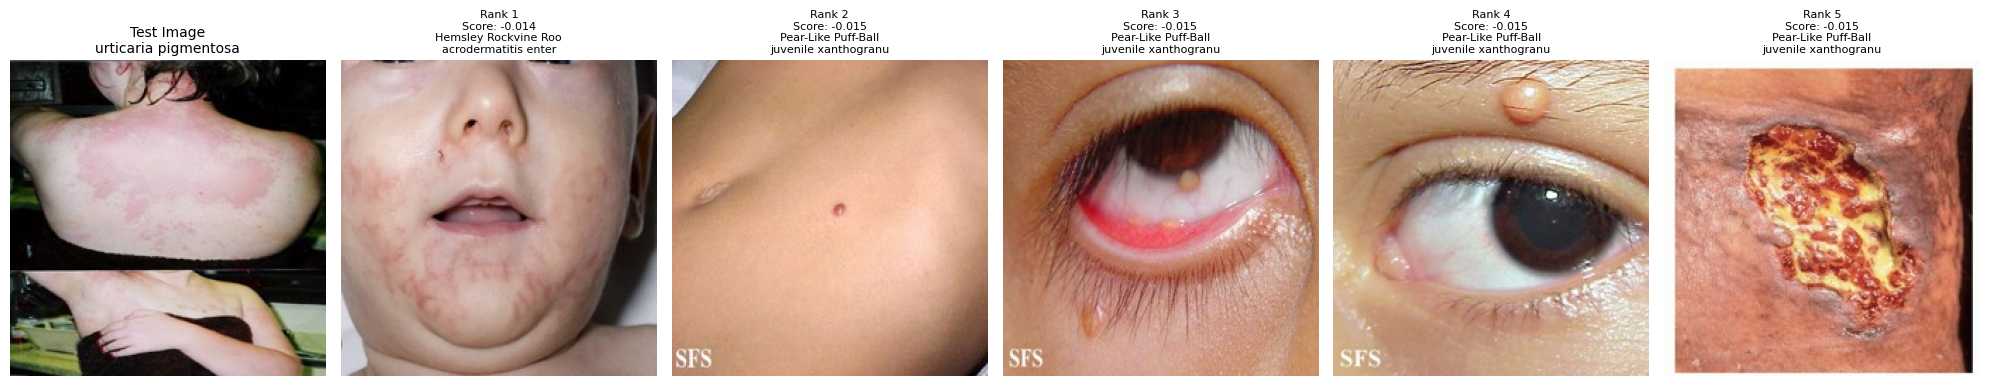


Test image 2/3:


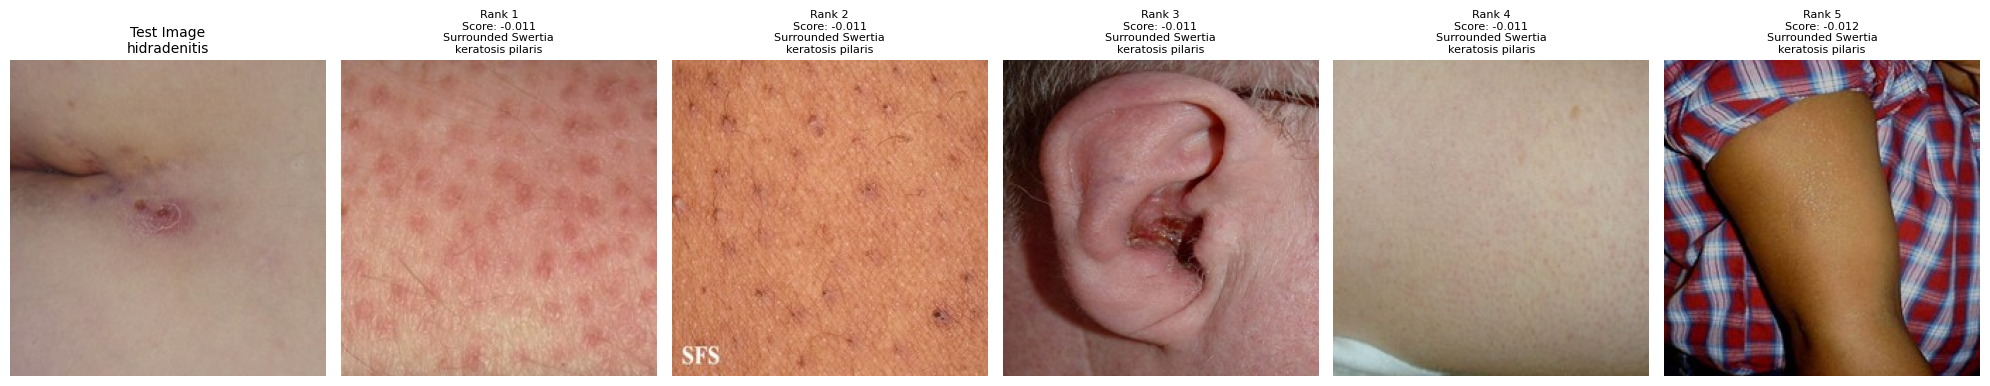


Test image 3/3:


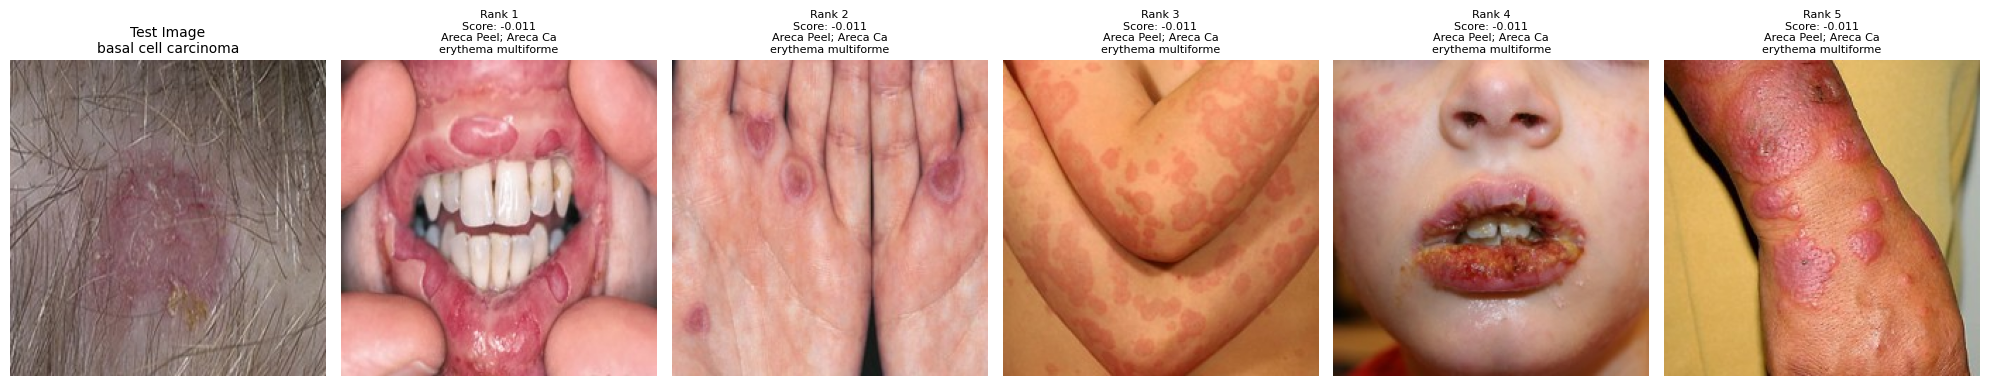

In [19]:
def visualize_test_predictions(test_idx: int, num_recommendations: int = 5):
    """
    Visualize top herb recommendations for a test image from train database.

    Args:
        test_idx: Index of the test image
        num_recommendations: Number of top recommendations to show
    """
    fig, axes = plt.subplots(1, num_recommendations + 1, figsize=(20, 4))

    # Display test query image
    query_img_path = test_df.iloc[test_idx]['image_path']
    query_img = Image.open(query_img_path)
    axes[0].imshow(query_img)
    axes[0].set_title(f"Test Image\n{test_df.iloc[test_idx]['label']}", fontsize=10)
    axes[0].axis('off')

    # Display top recommendations from train database
    for rank in range(num_recommendations):
        train_idx = top_k_indices[test_idx, rank].item()
        score = top_k_scores[test_idx, rank].item()

        herb_info = train_df.iloc[train_idx]
        herb_img_path = herb_info['image_path']
        herb_img = Image.open(herb_img_path)

        axes[rank + 1].imshow(herb_img)
        title = f"Rank {rank + 1}\nScore: {score:.3f}\n"
        title += f"{herb_info.get('Herb_Name', 'Unknown')[:20]}\n"
        title += f"{herb_info.get('label', 'Unknown')[:20]}"
        axes[rank + 1].set_title(title, fontsize=8)
        axes[rank + 1].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"test_prediction_{test_idx}.png"), dpi=150, bbox_inches='tight')
    plt.show()

# Visualize predictions for first 3 test images
if top_k_indices is not None and test_df is not None and train_df is not None:
    print("[PROCESS] Generating visualizations for sample test predictions...")
    num_samples = min(3, len(test_df))
    for i in range(num_samples):
        print(f"\nTest image {i+1}/{num_samples}:")
        visualize_test_predictions(i)
else:
    print("[ERROR] Cannot visualize - missing data")

## 17. Detailed Herb Recommendation Results


[PROCESS] Creating detailed herb recommendation visualizations...


Random Test Image 1/5 (Index: 3953)
[SAVED] Detailed visualization: /content/drive/MyDrive/499A Datasets/blip2_results/blip2_herb_recommendation_3953.png


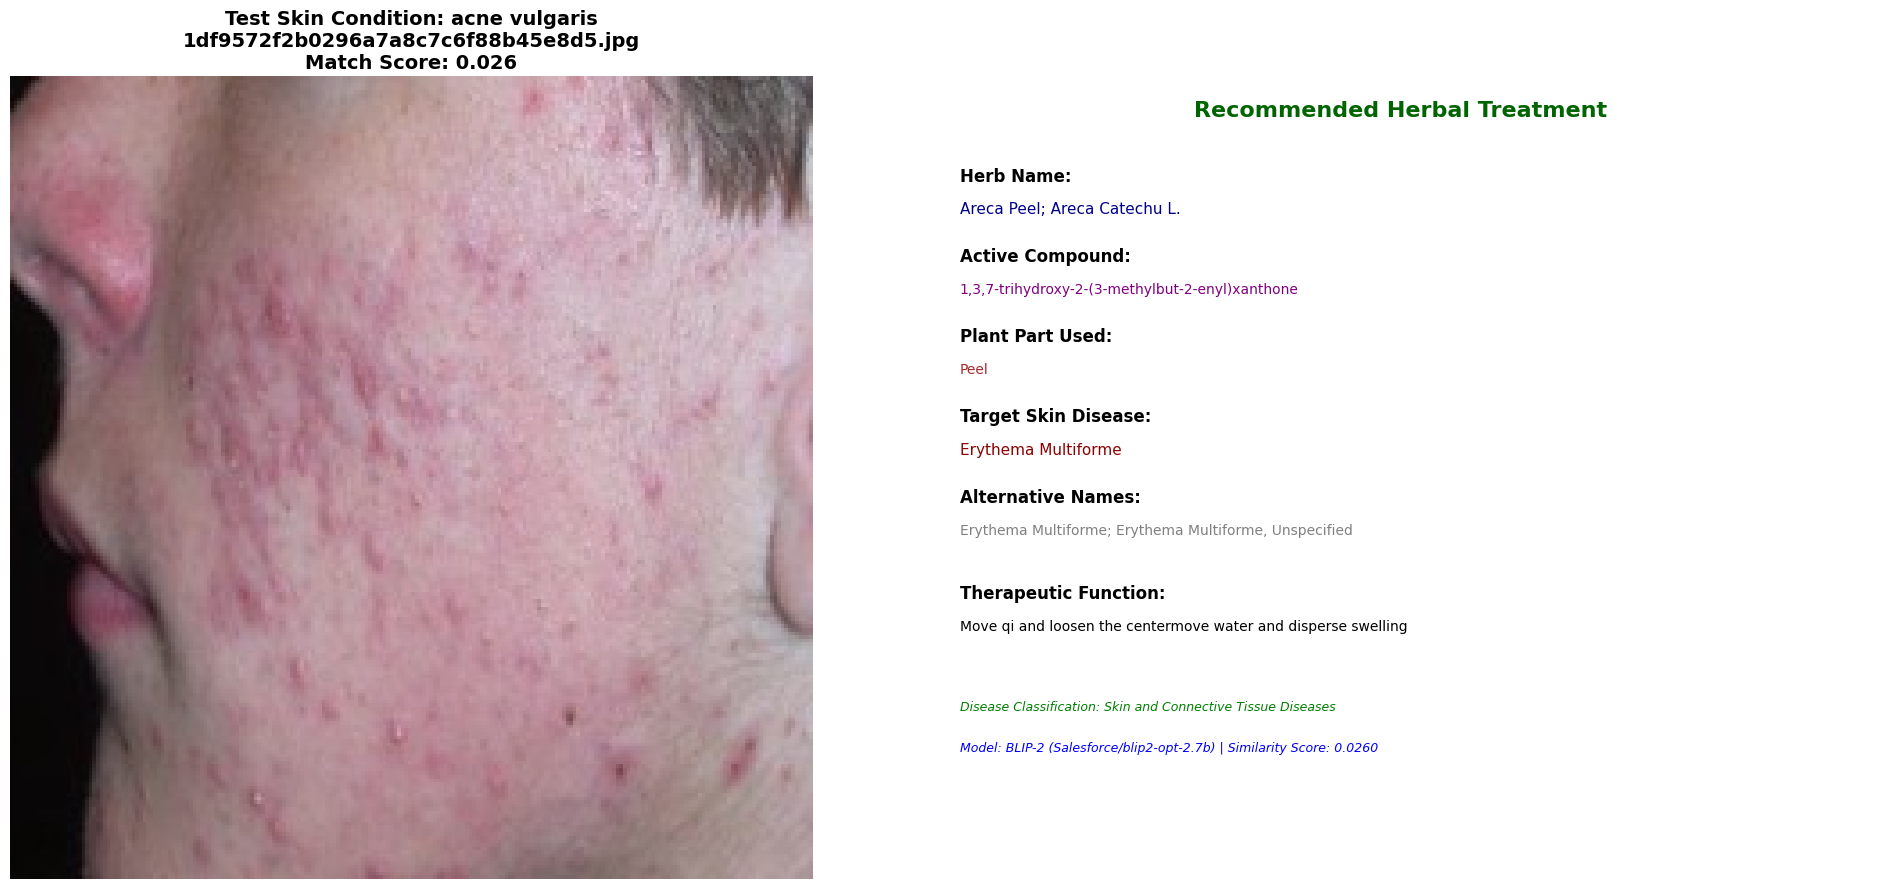



Random Test Image 2/5 (Index: 2867)
[SAVED] Detailed visualization: /content/drive/MyDrive/499A Datasets/blip2_results/blip2_herb_recommendation_2867.png


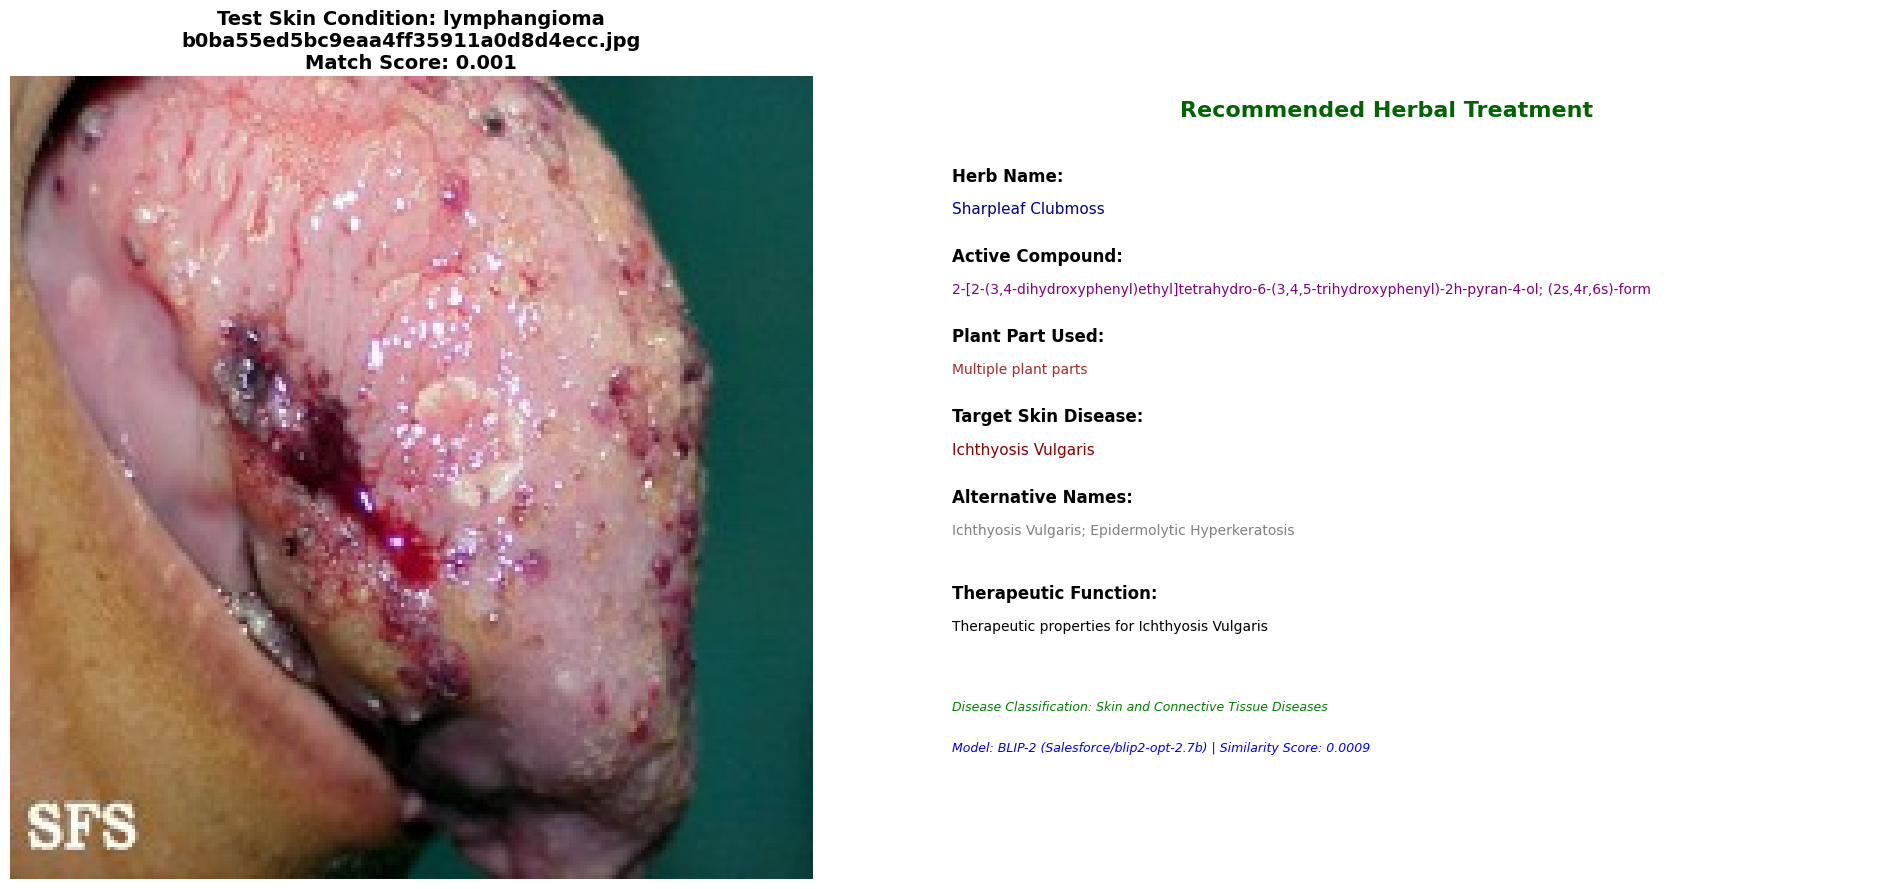



Random Test Image 3/5 (Index: 911)
[SAVED] Detailed visualization: /content/drive/MyDrive/499A Datasets/blip2_results/blip2_herb_recommendation_911.png


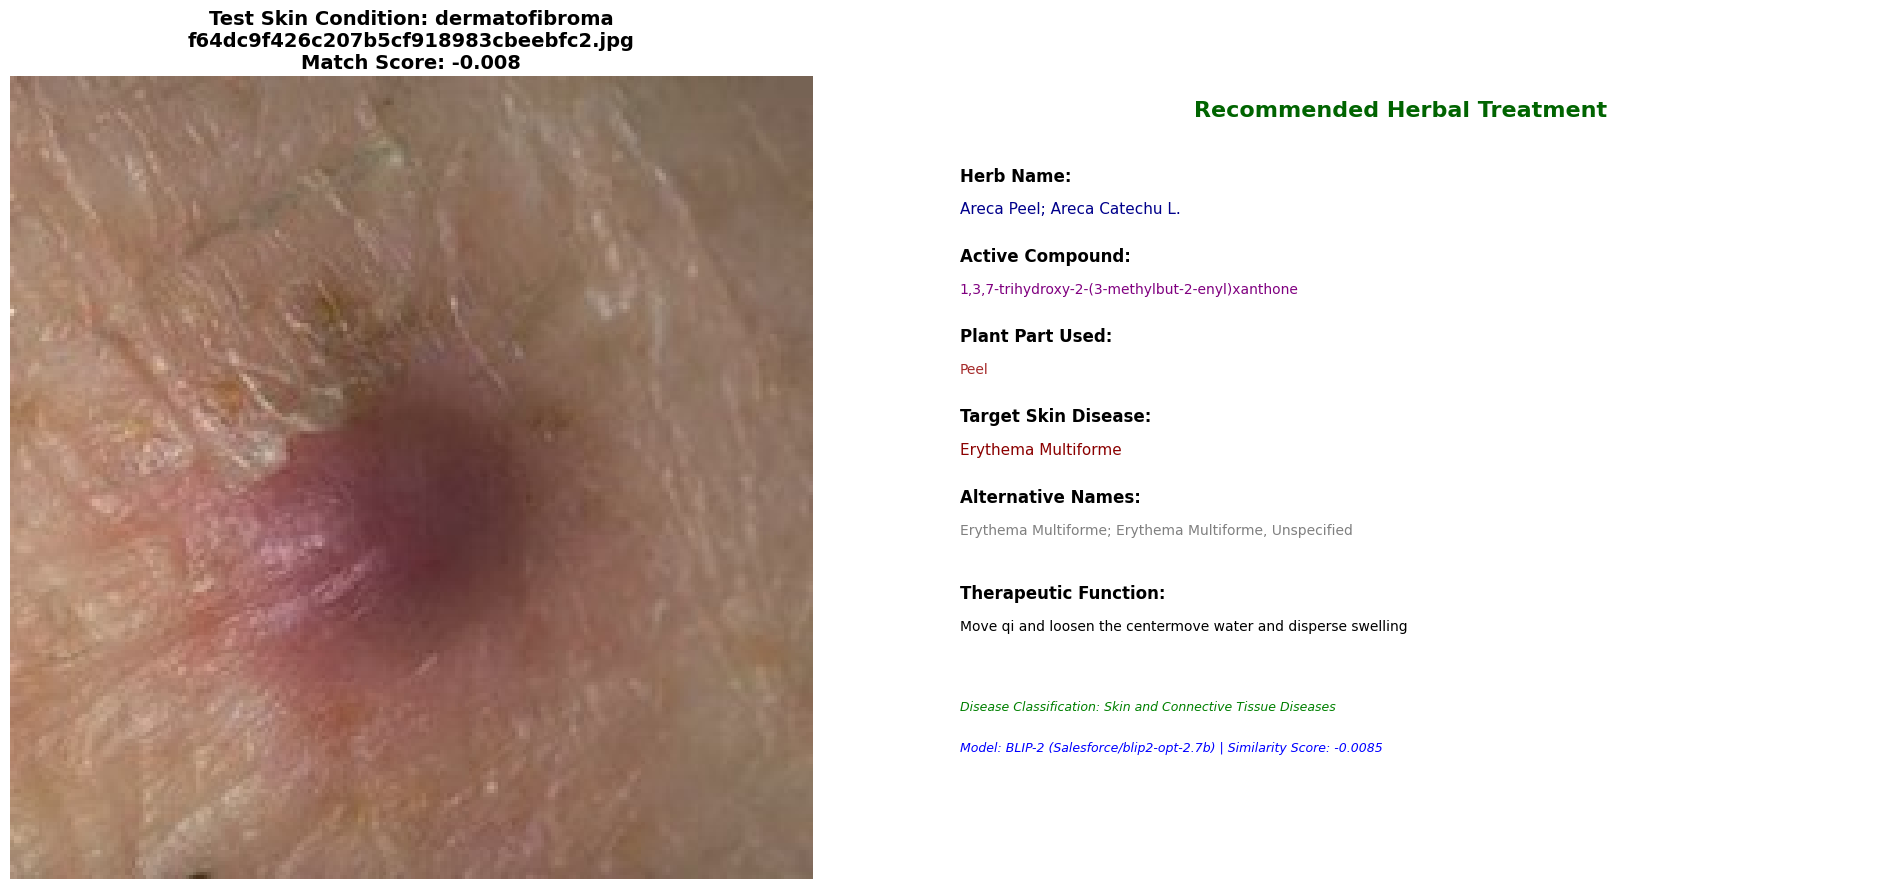



Random Test Image 4/5 (Index: 3015)
[SAVED] Detailed visualization: /content/drive/MyDrive/499A Datasets/blip2_results/blip2_herb_recommendation_3015.png


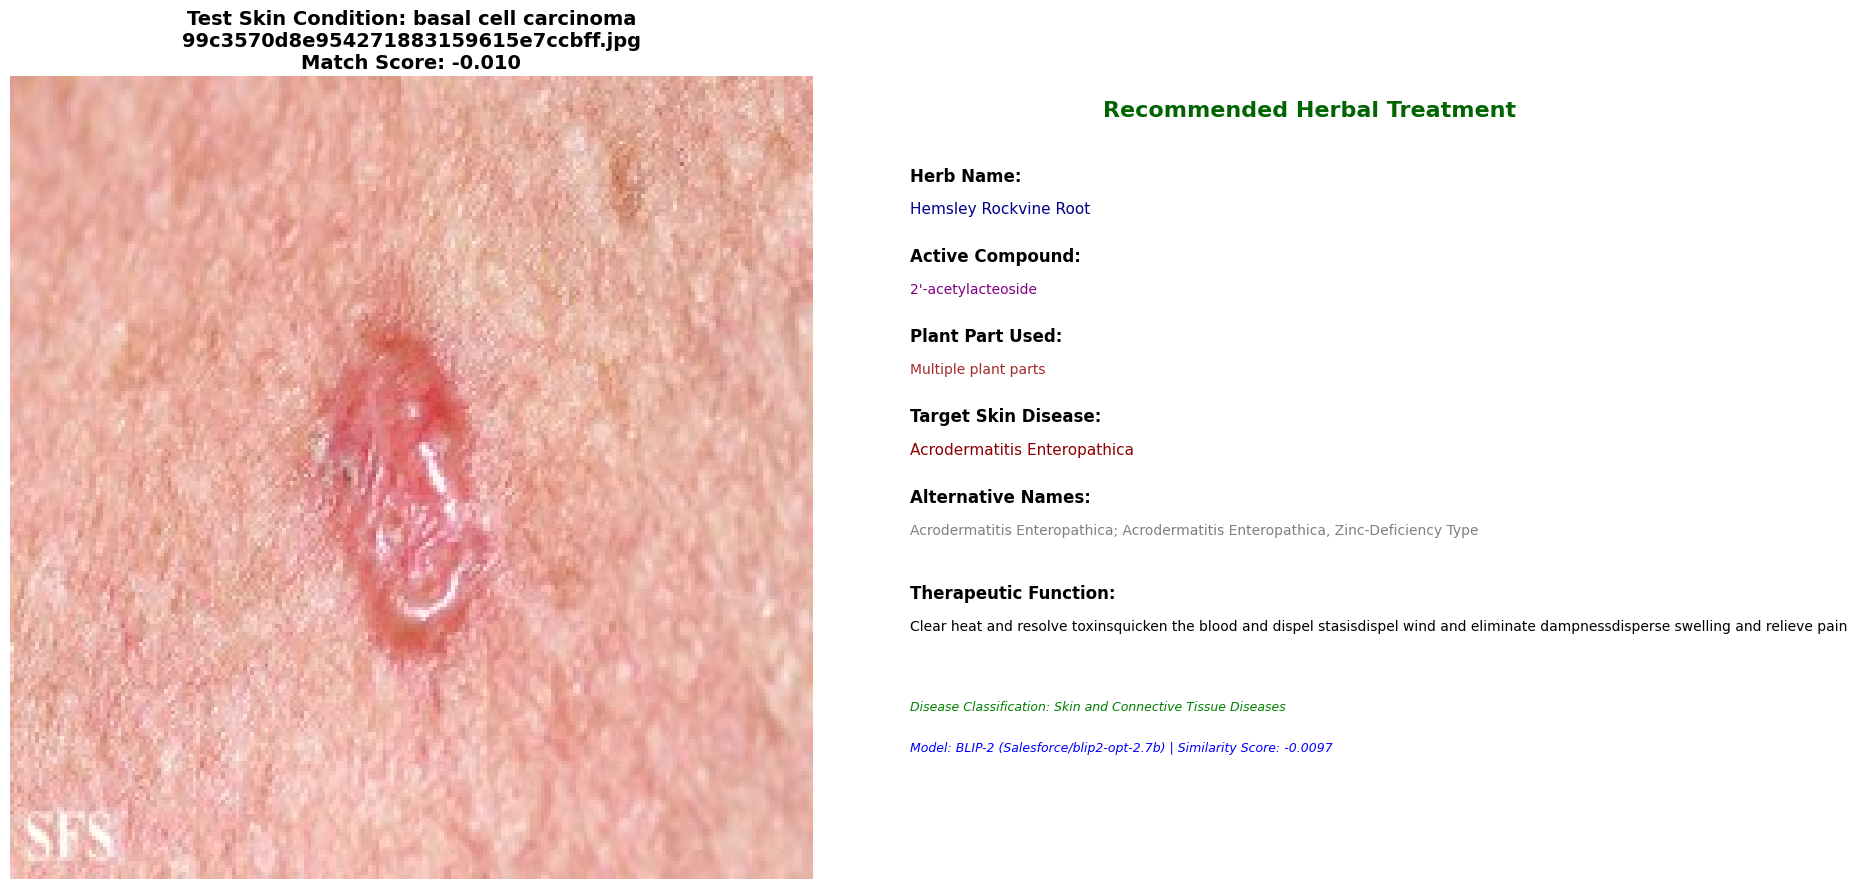



Random Test Image 5/5 (Index: 2732)
[SAVED] Detailed visualization: /content/drive/MyDrive/499A Datasets/blip2_results/blip2_herb_recommendation_2732.png


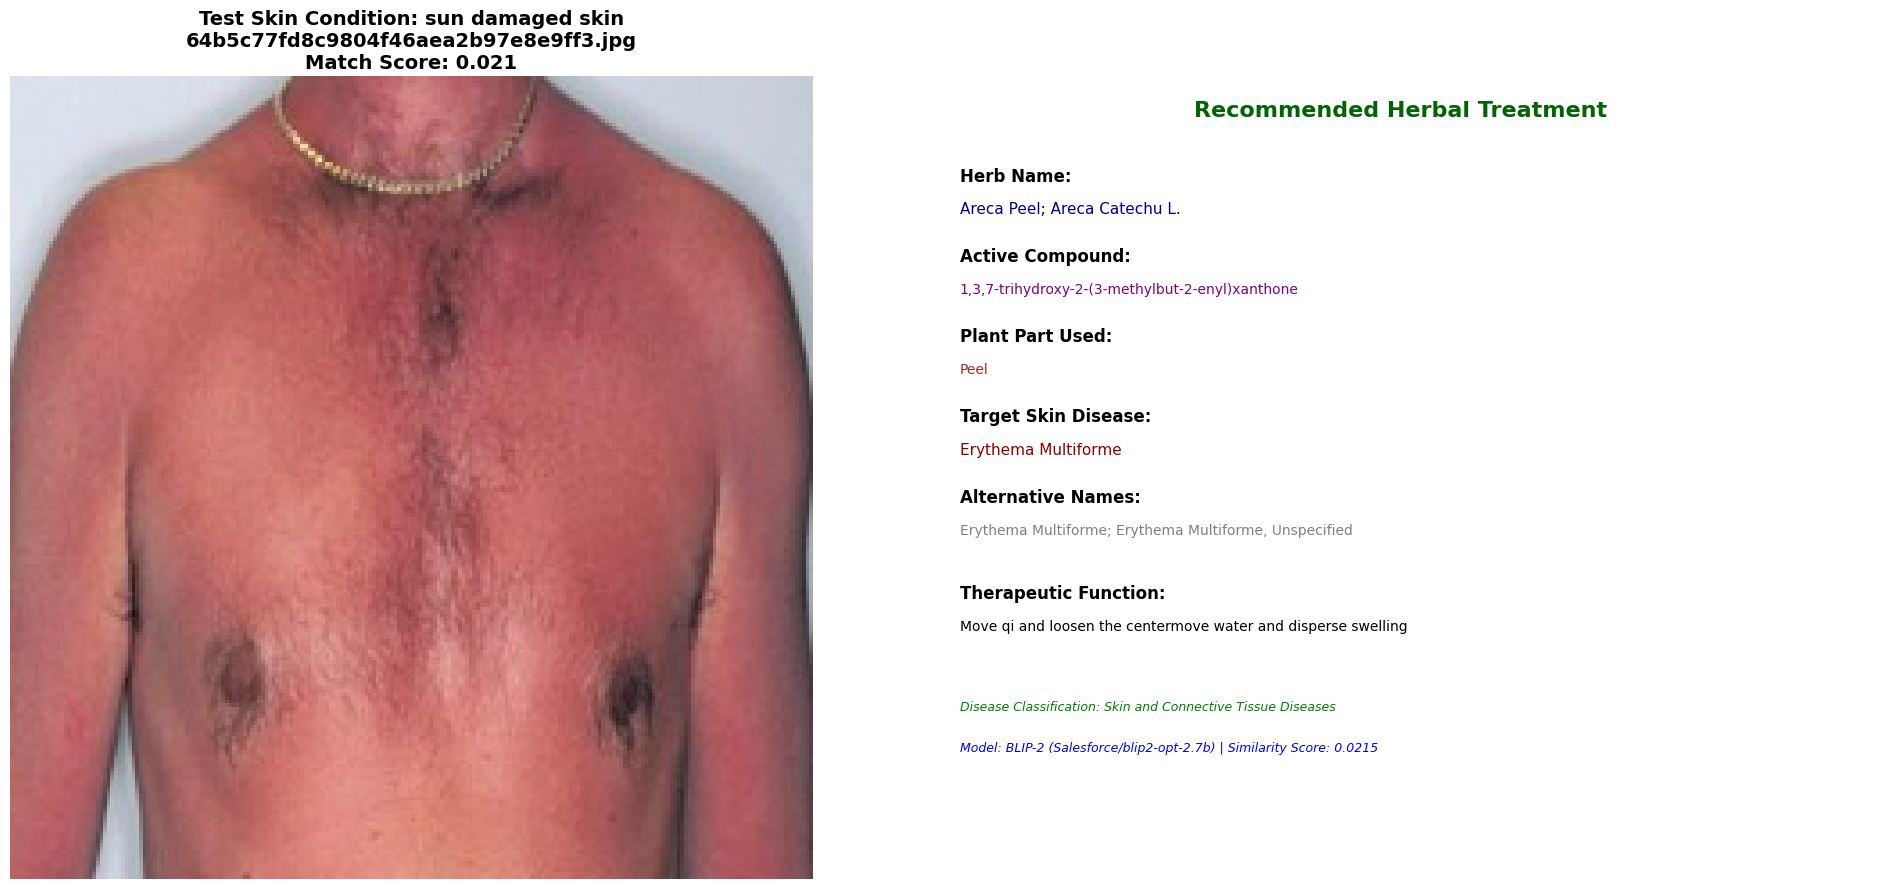

In [30]:
def display_herb_recommendation_details(test_idx: int):
    """
    Display comprehensive herb recommendation for a test image with all details.

    Args:
        test_idx: Index of the test image
    """
    if test_idx >= len(test_df):
        print(f"[ERROR] Invalid index: {test_idx}")
        return

    test_row = test_df.iloc[test_idx]

    # Get top recommendation
    top_train_idx = top_k_indices[test_idx, 0].item()
    top_score = top_k_scores[test_idx, 0].item()
    herb_row = train_df.iloc[top_train_idx]

    try:
        test_image = Image.open(test_row['image_path']).convert('RGB')
    except Exception as e:
        print(f"[ERROR] Error loading image: {e}")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))

    # Display test skin condition image
    ax1.imshow(test_image)
    ax1.axis('off')
    ax1.set_title(f"Test Skin Condition: {test_row['label']}\n{os.path.basename(test_row['image_path'])}\nMatch Score: {top_score:.3f}",
                 fontsize=14, fontweight='bold')

    # Display herb information
    ax2.axis('off')
    y = 0.95

    ax2.text(0.5, y, "Recommended Herbal Treatment",
            fontsize=16, fontweight='bold', ha='center', color='darkgreen')
    y -= 0.08

    # Herb Name
    ax2.text(0.05, y, "Herb Name:", fontsize=12, fontweight='bold')
    y -= 0.04
    herb_name = herb_row.get('Herb_Name', None)
    if pd.isna(herb_name) or herb_name is None or str(herb_name).strip() == '':
        herb_name = herb_row.get('Herb_en_name', 'Generic herbal treatment')
    if pd.isna(herb_name) or herb_name is None or str(herb_name).strip() == '':
        herb_name = 'Generic herbal treatment'
    ax2.text(0.05, y, str(herb_name), fontsize=11, color='darkblue')
    y -= 0.06

    # Active Ingredient/Compound
    ingredient = herb_row.get('Ingredient_name', None)
    if pd.notna(ingredient) and isinstance(ingredient, str):
        ax2.text(0.05, y, "Active Compound:", fontsize=12, fontweight='bold')
        y -= 0.04
        ingredient_text = str(ingredient)[:100]
        ax2.text(0.05, y, ingredient_text, fontsize=10, color='purple')
        y -= 0.06

    # Plant Part Used (Always display)
    ax2.text(0.05, y, "Plant Part Used:", fontsize=12, fontweight='bold')
    y -= 0.04
    use_part = herb_row.get('Use_Part', None)
    if pd.notna(use_part) and isinstance(use_part, str) and str(use_part).strip() != '':
        use_part_text = str(use_part)[:80]
    else:
        use_part_text = 'Multiple plant parts'
    ax2.text(0.05, y, use_part_text, fontsize=10, color='brown')
    y -= 0.06

    # Target Disease
    ax2.text(0.05, y, "Target Skin Disease:", fontsize=12, fontweight='bold')
    y -= 0.04
    disease_name = herb_row.get('Disease_Name', test_row['label'])
    if not isinstance(disease_name, str) or pd.isna(disease_name):
        disease_name = test_row['label']
    ax2.text(0.05, y, disease_name, fontsize=11, color='darkred')
    y -= 0.06

    # Disease Aliases
    disease_alias = herb_row.get('Disease_Alias_Name', None)
    if pd.notna(disease_alias) and isinstance(disease_alias, str):
        ax2.text(0.05, y, "Alternative Names:", fontsize=12, fontweight='bold')
        y -= 0.04
        aliases = str(disease_alias)[:120]
        ax2.text(0.05, y, aliases, fontsize=10, color='gray', wrap=True)
        y -= 0.08

    # Herb Function/Therapeutic Effect
    ax2.text(0.05, y, "Therapeutic Function:", fontsize=12, fontweight='bold')
    y -= 0.04
    function = herb_row.get('Herb_Function', 'Therapeutic properties for skin treatment')
    if not isinstance(function, str) or pd.isna(function):
        function = f'Therapeutic properties for {disease_name}'
    function_text = str(function)[:250]
    ax2.text(0.05, y, function_text, fontsize=10, wrap=True, color='black')
    y -= 0.10

    # Disease Classification
    ax2.text(0.05, y, "Disease Classification: Skin and Connective Tissue Diseases",
            fontsize=9, style='italic', color='green')
    y -= 0.05

    # Model Information
    ax2.text(0.05, y, f"Model: BLIP-2 (Salesforce/blip2-opt-2.7b) | Similarity Score: {top_score:.4f}",
            fontsize=9, style='italic', color='blue')

    plt.tight_layout()

    output_path = os.path.join(OUTPUT_DIR, f'blip2_herb_recommendation_{test_idx}.png')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"[SAVED] Detailed visualization: {output_path}")
    plt.show()


# Display detailed herb recommendations for randomly selected test images
if top_k_indices is not None and test_df is not None and train_df is not None:
    print("\n[PROCESS] Creating detailed herb recommendation visualizations...\n")

    # Change this number to visualize more/fewer images (e.g., 5, 10, 20)
    num_samples = min(5, len(test_df))

    # Randomly select test image indices from entire test set
    random_indices = np.random.choice(len(test_df), size=num_samples, replace=False)

    for idx, test_idx in enumerate(random_indices, 1):
        print(f"\n{'='*70}")
        print(f"Random Test Image {idx}/{num_samples} (Index: {test_idx})")
        print(f"{'='*70}")
        display_herb_recommendation_details(test_idx)
        print()
else:
    print("[ERROR] Cannot create detailed recommendations - missing data")


## 18. Summary Statistics

In [32]:
print("[INFO] BLIP-2 Project Summary with Train/Test Split")


print("\n[MODEL CONFIGURATION]")
print(f"  Model: {MODEL_NAME}")
print(f"  Device: {device.upper()}")
print(f"  Total Parameters: {total_params / 1e9:.2f}B")

if train_df is not None and test_df is not None:
    print("\n[DATASET STATISTICS]")
    print(f"  Total samples: {len(train_df) + len(test_df):,}")
    print(f"  Train samples: {len(train_df):,} (70%)")
    print(f"  Test samples: {len(test_df):,} (30%)")
    print(f"  Unique diseases (train): {train_df['label'].nunique()}")
    print(f"  Unique diseases (test): {test_df['label'].nunique()}")

if train_image_features is not None and train_text_features is not None:
    print("\n[FEATURE DIMENSIONS]")
    print(f"  Train image features: {train_image_features.shape}")
    print(f"  Train text features: {train_text_features.shape}")
    if test_image_features is not None:
        print(f"  Test image features: {test_image_features.shape}")
    if similarity_matrix is not None:
        print(f"  Similarity matrix: {similarity_matrix.shape}")

print("\n[EVALUATION RESULTS - TEST SET]")
print(f"  Recall@1: {recall_at_1:.4f} ({recall_at_1*100:.2f}%)")
print(f"  Recall@3: {recall_at_3:.4f} ({recall_at_3*100:.2f}%)")
print(f"  Recall@5: {recall_at_5:.4f} ({recall_at_5*100:.2f}%)")
print(f"  Mean Reciprocal Rank: {mrr:.4f}")

print("\n[OUTPUT FILES]")
print(f"  Train split: {BASE_DIR}/blip2_train_split.csv")
print(f"  Test split: {BASE_DIR}/blip2_test_split.csv")
print(f"  Test results: {OUTPUT_DIR}/blip2_test_recommendations.csv")
print(f"  Test metrics: {OUTPUT_DIR}/blip2_test_evaluation_metrics.json")
print(f"  Train image features: {EMB_SAVE_DIR}/train_image_features.pt")
print(f"  Test image features: {EMB_SAVE_DIR}/test_image_features.pt")
print(f"  Train text features: {EMB_SAVE_DIR}/train_text_features.pt")
print(f"  Similarity matrix: {EMB_SAVE_DIR}/test_train_similarity_matrix.pt")



[INFO] BLIP-2 Project Summary with Train/Test Split

[MODEL CONFIGURATION]
  Model: Salesforce/blip2-opt-2.7b
  Device: CUDA
  Total Parameters: 3.74B

[DATASET STATISTICS]
  Total samples: 16,518
  Train samples: 11,562 (70%)
  Test samples: 4,956 (30%)
  Unique diseases (train): 114
  Unique diseases (test): 114

[FEATURE DIMENSIONS]
  Train image features: torch.Size([11562, 1408])
  Train text features: torch.Size([11562, 2560])
  Test image features: torch.Size([4956, 1408])
  Similarity matrix: torch.Size([4956, 11562])

[EVALUATION RESULTS - TEST SET]
  Recall@1: 0.0113 (1.13%)
  Recall@3: 0.0131 (1.31%)
  Recall@5: 0.0133 (1.33%)
  Mean Reciprocal Rank: 0.0123

[OUTPUT FILES]
  Train split: /content/drive/MyDrive/499A Datasets/blip2_train_split.csv
  Test split: /content/drive/MyDrive/499A Datasets/blip2_test_split.csv
  Test results: /content/drive/MyDrive/499A Datasets/blip2_results/blip2_test_recommendations.csv
  Test metrics: /content/drive/MyDrive/499A Datasets/blip2_resu